![teaser](img/decisionmaking.png)

**ELEC-E7890 - User Research**

Lecture 8 - Developing Brain-Computer Interfaces

**Carlos de la Torre Ortiz**

University of Helsinki

<div class="alert alert-block alert-success">
<h2><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Learning objectives</h2>
<ul>
<li>Adquiring the flexibility to work with domain-specific tools.</li>
<li>Handling and processing real user data.</li>
<li>Drafting interactive methods accounting for data limitations.</li>
</ul>
</div>

#### Python setup <a class="tocSkip"></a>

In [36]:
# Import the libraries.
import os
import sys

from autoreject import Ransac
from autoreject.utils import interpolate_bads
import matplotlib.pyplot as plt
import mne
from mne.datasets import spm_face
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

plt.close("all")
sns.set_theme(context="notebook", style="white")

%config InlineBackend.figure_format="retina"

sep = lambda: print("-" * 30)

# Data and tools

## MEG

Remember there is a signal that is recorded from many sensors from a subject:
    
![MEG setup](img/lec8/meg-sensors.png)

Each sensor is recording activity over time, so data will look like this:

![MEG data](img/lec8/meg-data.png)

In the vertical axis we have channels and in the horizontal one time.
For each channel, the vertical axis represents the magnetic field of the brain, usually in femtotesla (fT).

**Extra**

- What is "femto": https://en.wikipedia.org/wiki/Metric_prefix#List_of_SI_prefixes
- What is "tesla": https://en.wikipedia.org/wiki/Tesla_(unit)
- About MEG: https://en.wikipedia.org/wiki/Magnetoencephalography

## MNE

![MNE logo](img/lec8/mne_logo.svg)

Neurophysiological data pipelines are often complex and long.
MNE will do most heavy lifting for us.
From https://mne.tools:

"Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more."

- Source Estimation
- Machine Learning
- Encoding Models
- Statistics
- Connectivity
- Data Visualization

Most of this notebook borrows heavily from the official tutorials, so please be welcome to pay them a visit!

<div class="alert alert-block alert-info">
    
Note that MNE will help us a lot but learning how to use it is NOT a learning objective!
</div>

## Dataset

MNE can download and use many sample datasets and we will use the SPM dataset.
From https://mne.tools/stable/overview/datasets_index.html#spm-faces:

"The SPM faces dataset contains EEG, MEG and fMRI recordings on face perception." (https://www.fil.ion.ucl.ac.uk/spm/data/mmfaces/)

This dataset contains **evoked** responses to visual stimuli.
Participants were shown a mix of images of:

- "normal"-looking faces 
- "scrambled" faces.

![Normal and scrambled faces](img/lec8/stimuli.png)
(from https://www.fil.ion.ucl.ac.uk/spm/doc/spm8_manual.pdf)

Preprocessing will be mostly taken from:
https://mne.tools/stable/auto_examples/datasets/spm_faces_dataset_sgskip.html#ex-spm-faces

<div class="alert alert-block alert-info">
<h4><img src="img/logo/goal.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Goal</h4> 
    
Detect whether the study participant saw a normal face or not based exclusively on brain signals.
</div>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    
Neurophysiological recordings very often result in:

<ul>
    <li>HUGE file sizes in disk.</li>
    <li>Also meaning, huge file sizes in RAM to work with them.</li>
</ul>
    
<strong>One way to mitigate this is to force most operations to be in place</strong>, so there're very few copies of similar variables around.
MNE, the package that we'll use to work the EEG data, follows this strategy.
<strong>If you don't know what this means, please see the end of the notebook.</strong>
<em>In short, always consider that is easy to accidentaly modify the values of your variables!</em>
</div>

# Exploring the Raw data

We will load the Raw data itself contained in the `mne.io.Raw` object and explore what kind of object it is.

##### Loading the data <a class="tocSkip"></a>

In [37]:
# Define the paths

data_path = spm_face.data_path()  # Will download the data if not present
raw_path = os.path.join(
    data_path, "MEG", "spm", "SPM_CTF_MEG_example_faces%d_3D.ds"
)

print(raw_path)

/home/c/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces%d_3D.ds


In [38]:
# WARNING: slow!
# Read the data, taking only the first run
raw = io.read_raw_ctf(raw_path % 1, preload=True)

##### Type of Raw object <a class="tocSkip"></a>

In [39]:
type(raw)

mne.io.ctf.ctf.RawCTF

##### Displaying raw metadata <a class="tocSkip"></a>

The `info` method accesses the raw metadata is one of the most used.
https://mne.tools/stable/generated/mne.Info.html

In [40]:
# Display metadata
raw.info

<Info | 15 non-empty values
 bads: []
 ch_names: UPPT002, UPPT001, SCLK01-177, BG1-2908, BG2-2908, BG3-2908, ...
 chs: 2 STIM, 35 MISC, 29 REF_MEG, 274 MAG
 comps: 5 items (list)
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 hpi_results: 1 item (list)
 lowpass: 240.0 Hz
 meas_date: 2008-11-24 09:54:00 UTC
 meas_id: 4 items (dict)
 nchan: 340
 projs: []
 sfreq: 480.0 Hz
 subject_info: 1 item (dict)
>

##### Getting the values <a class="tocSkip"></a>

OK but if we expected some continuous data, where are the values?
Aren't we expecting some sort of array?

Yes!
But MNE is keeping an object with advanced functionality for us, not just an array:

In [41]:
data = raw.get_data()
data

array([[ 2.55000000e+02,  2.55000000e+02,  2.55000000e+02, ...,
         2.55000000e+02,  2.55000000e+02,  2.55000000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.17691750e+03,  3.17691958e+03,  3.17692167e+03, ...,
         3.85289875e+03,  3.85290083e+03,  3.85290292e+03],
       ...,
       [-4.52070000e-02, -4.52070000e-02, -4.52070000e-02, ...,
        -4.63990000e-02, -4.63990000e-02, -4.63990000e-02],
       [-2.58000000e-01, -2.58000000e-01, -2.58000000e-01, ...,
        -2.55098000e-01, -2.55098000e-01, -2.55098000e-01],
       [ 3.81220850e+01,  3.81220850e+01,  3.81220850e+01, ...,
         4.62340850e+01,  4.62340850e+01,  4.62340850e+01]])

In [42]:
data.shape

(340, 324474)

##### Plotting the data <a class="tocSkip"></a>

We often want the same plots at early stages for certain neurophysiological data types.
MNE has some convenience methods for this (which you don't need to memorize)

Let's see a sample of the data!

Shape is (n_channels, n_times).
How does it compare to `raw.info`?

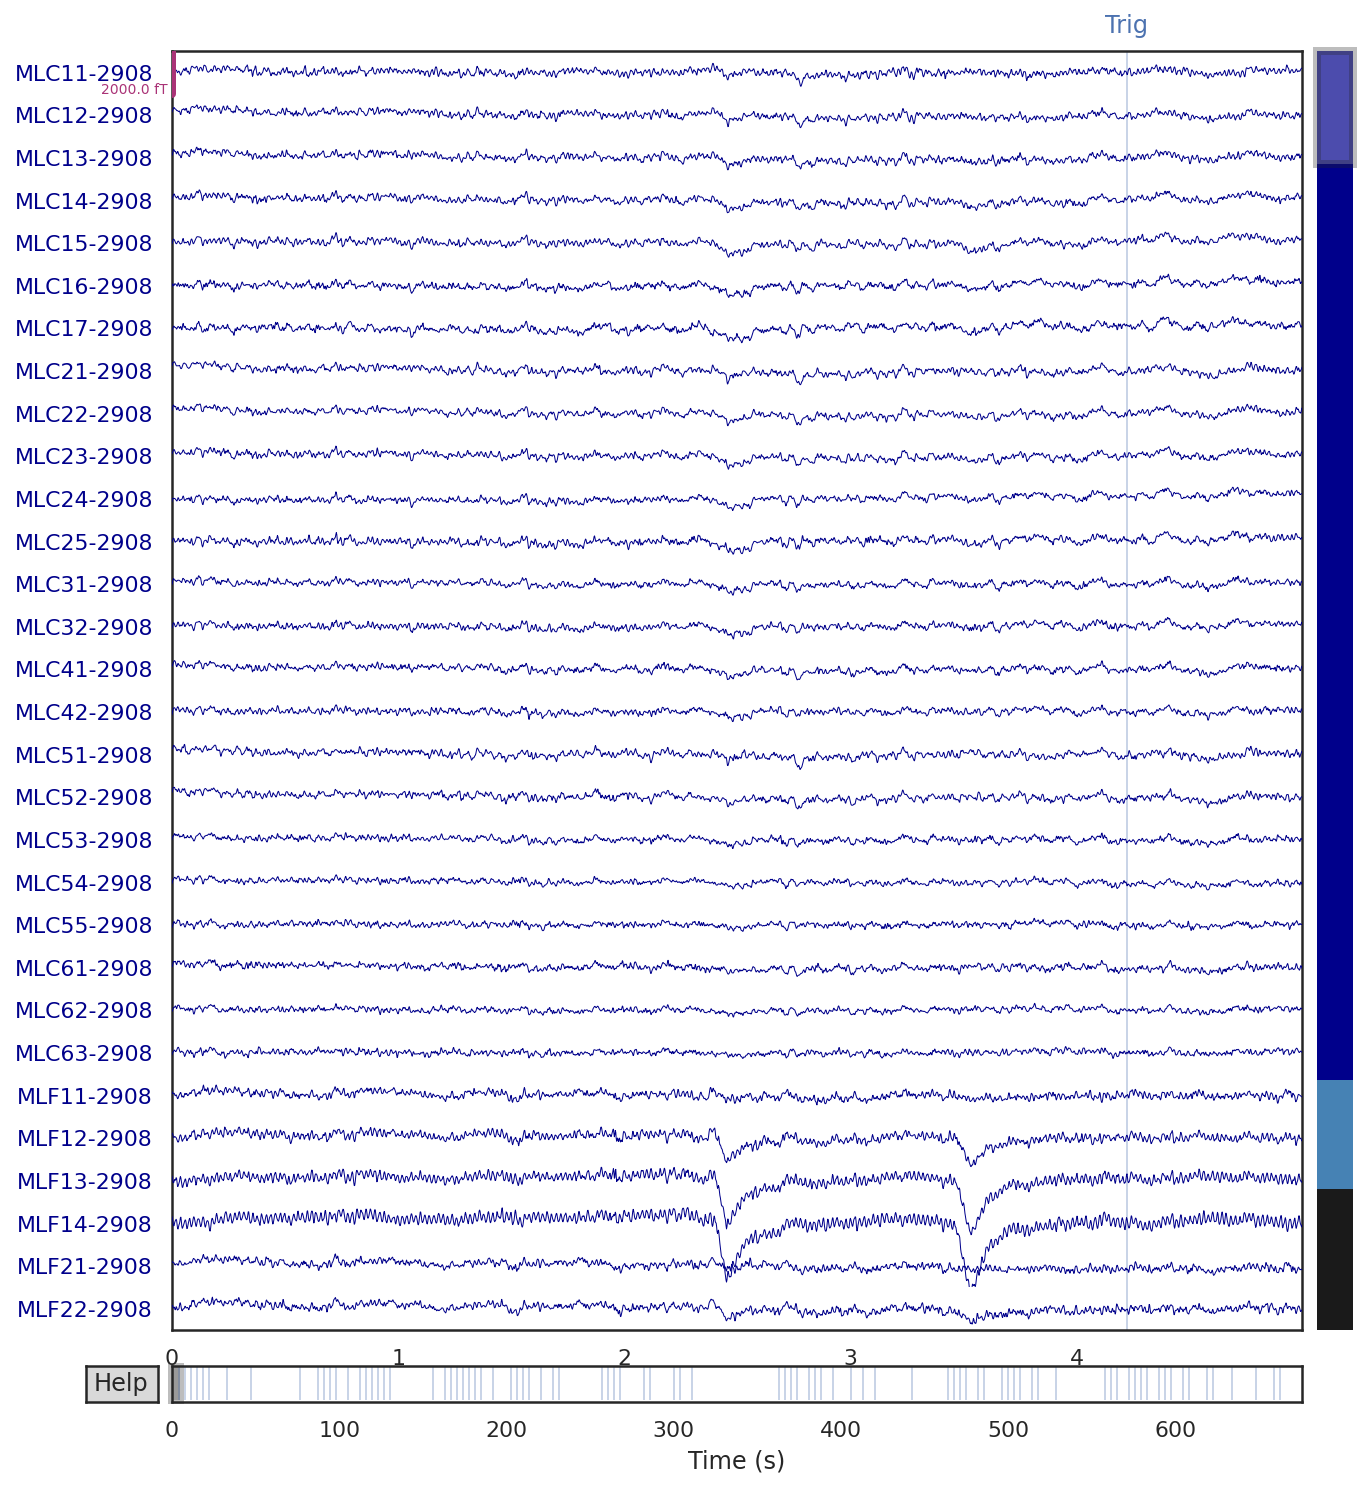

In [43]:
_ = raw.plot(duration=5, n_channels=30)

OPTIONAL:

1. Run the code up to here as a Python script (**not** notebook) to spawn *interactive* data visualization and annotation.
2. Use the horizontal and vertical scroll bars to browse the data.
3. Do you see bad channels? Click on them! They should become gray.
4. Close the window when done.

TIP: Don't reinvent the wheel. Often there is a library for your use case out there. Or many time a method to do what you want inside the library you're already using.
Doing a brief search before you start programming can save you a lot of time and headaches!

# Downsampling

To save memory and speed computations, we can downsample the data heavily.
It is not recommended to do it here since it can break the metadata ("jitter triggers") associated with the signal.
Still, we will take the risk to speed things up for the lecture.

Resampling applies a low-pass FIR filter and then selects only a few points from the data.

https://mne.tools/stable/overview/faq.html#resampling-and-decimating

##### Applying downsampling <a class="tocSkip"></a>

In [44]:
size_before = sys.getsizeof(raw.get_data())
raw.resample(120., npad='auto')
size_after = sys.getsizeof(raw.get_data())

In [45]:
print(f"Before:\t{size_before} bytes")
print(f"After:\t{size_after} bytes")
diff = size_after - size_before
sep()
print(f"Diff:\t{diff} bytes")
perc = -(size_before // size_after) * 100
print(f"%:\t{perc}%")

Before:	882569400 bytes
After:	220641080 bytes
------------------------------
Diff:	-661928320 bytes
%:	-400%


# Selecting the channels

We will pick MEG channels since it's more documented for this dataset example.
Bad channels are channels with very high noise or near-zero activity (in EEG, imagine an electrode that detached from the scalp).

##### Applying selection <a class="tocSkip"></a>

In [46]:
picks = mne.pick_types(raw.info, meg=True, exclude='bads')
print(picks)

[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 24

In this example, we used the "bads" that were pre-encoded in the raw metadata.
Later, we'll double-check for bad channels using an automated approach.

# Filtering

Unfortunately neurophysiological data is very often noisy, so filtering is applied extensively.

It's a bit diffucult to understand the details of how filtering works.
If you're interested and want to see a hands in demo, please check https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html

<div class="alert alert-block alert-info">
As an intuition, we define two frequency thresholds, and only let data pass between those.
</div>

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    
We are using <strong>frequency</strong> filters and not <strong>amplitude</strong> filters:
bigger or smaller peaks in the data will often look the same size after filtering.
We'll perceive a less noisy or "jagged" signal instead.
</div>

##### Applying filters <a class="tocSkip"></a>

1. Plot the data before filtering.
2. Apply a filter for 1 and 30 Hz.
3. Repeat the same plot.

Do you observe any difference?

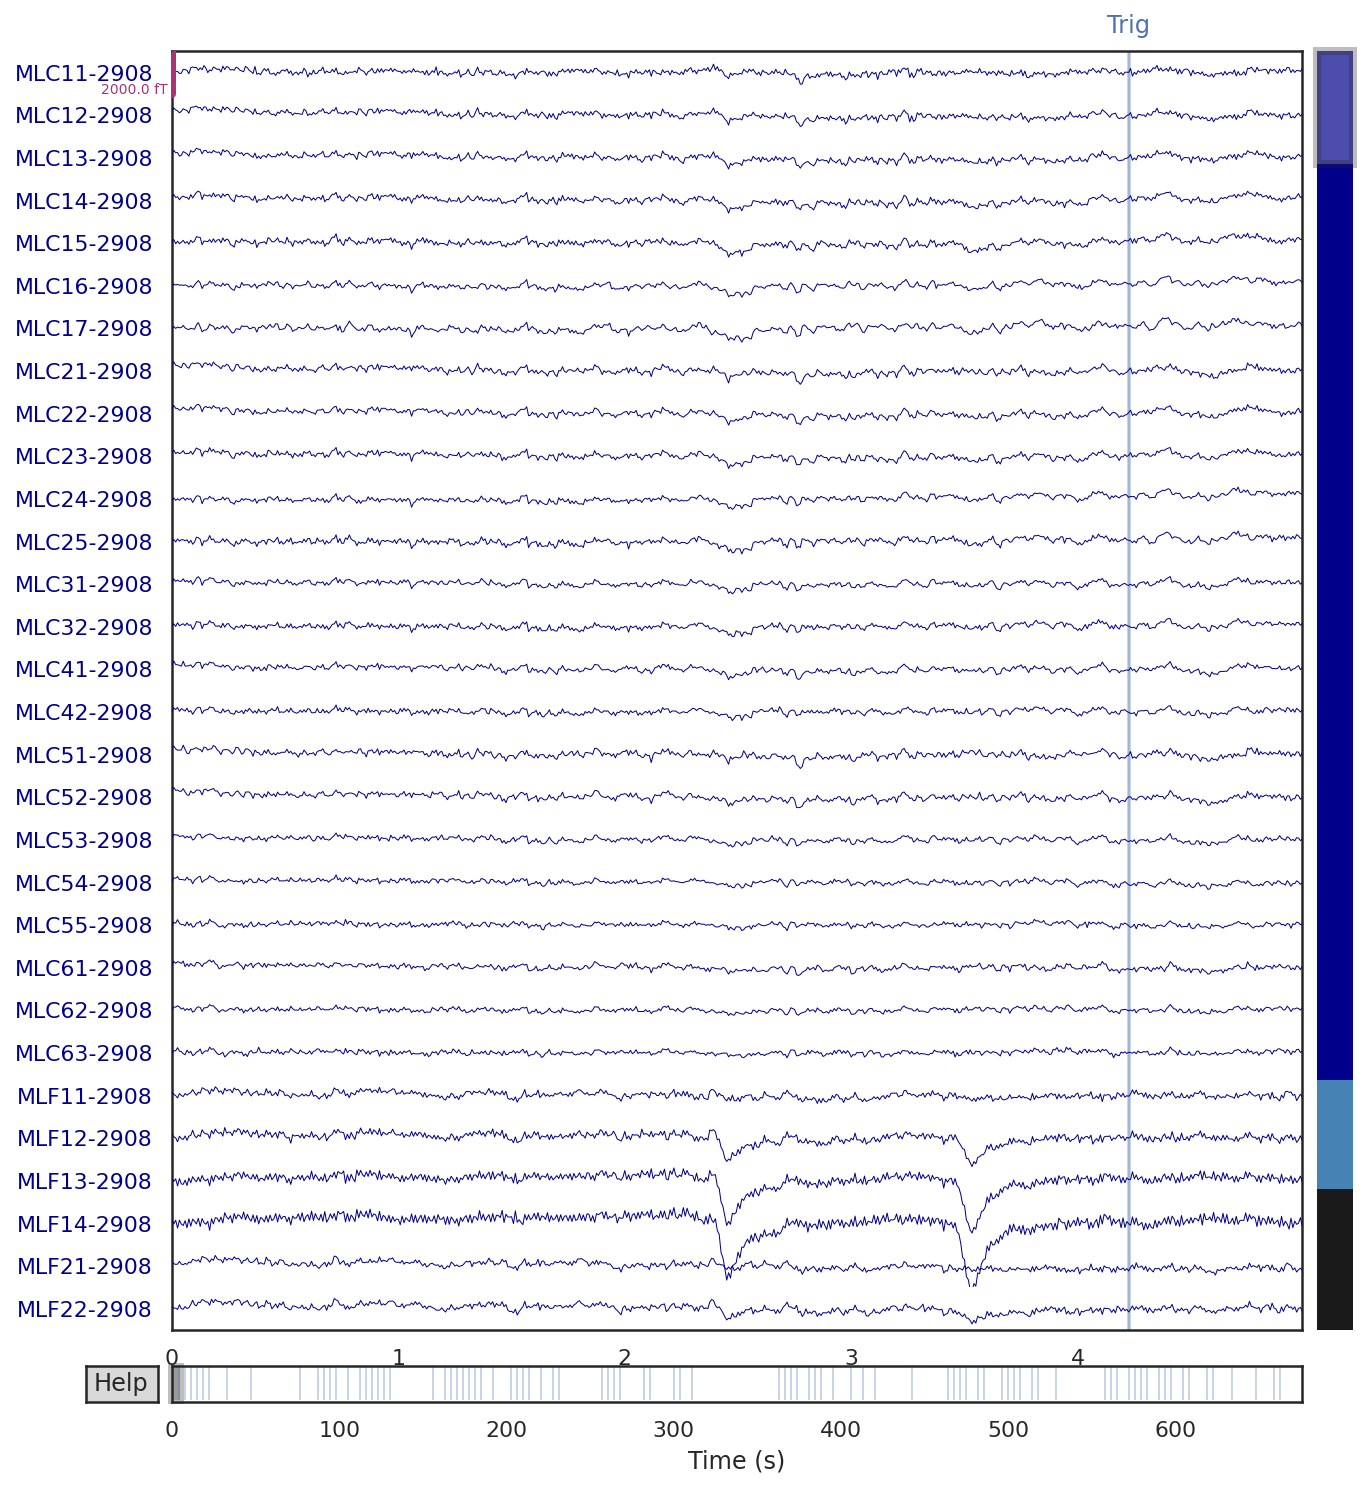

In [47]:
_ = raw.plot(duration=5, n_channels=30)

In [48]:
_ = raw.filter(1, 30, method='fir', fir_design='firwin')

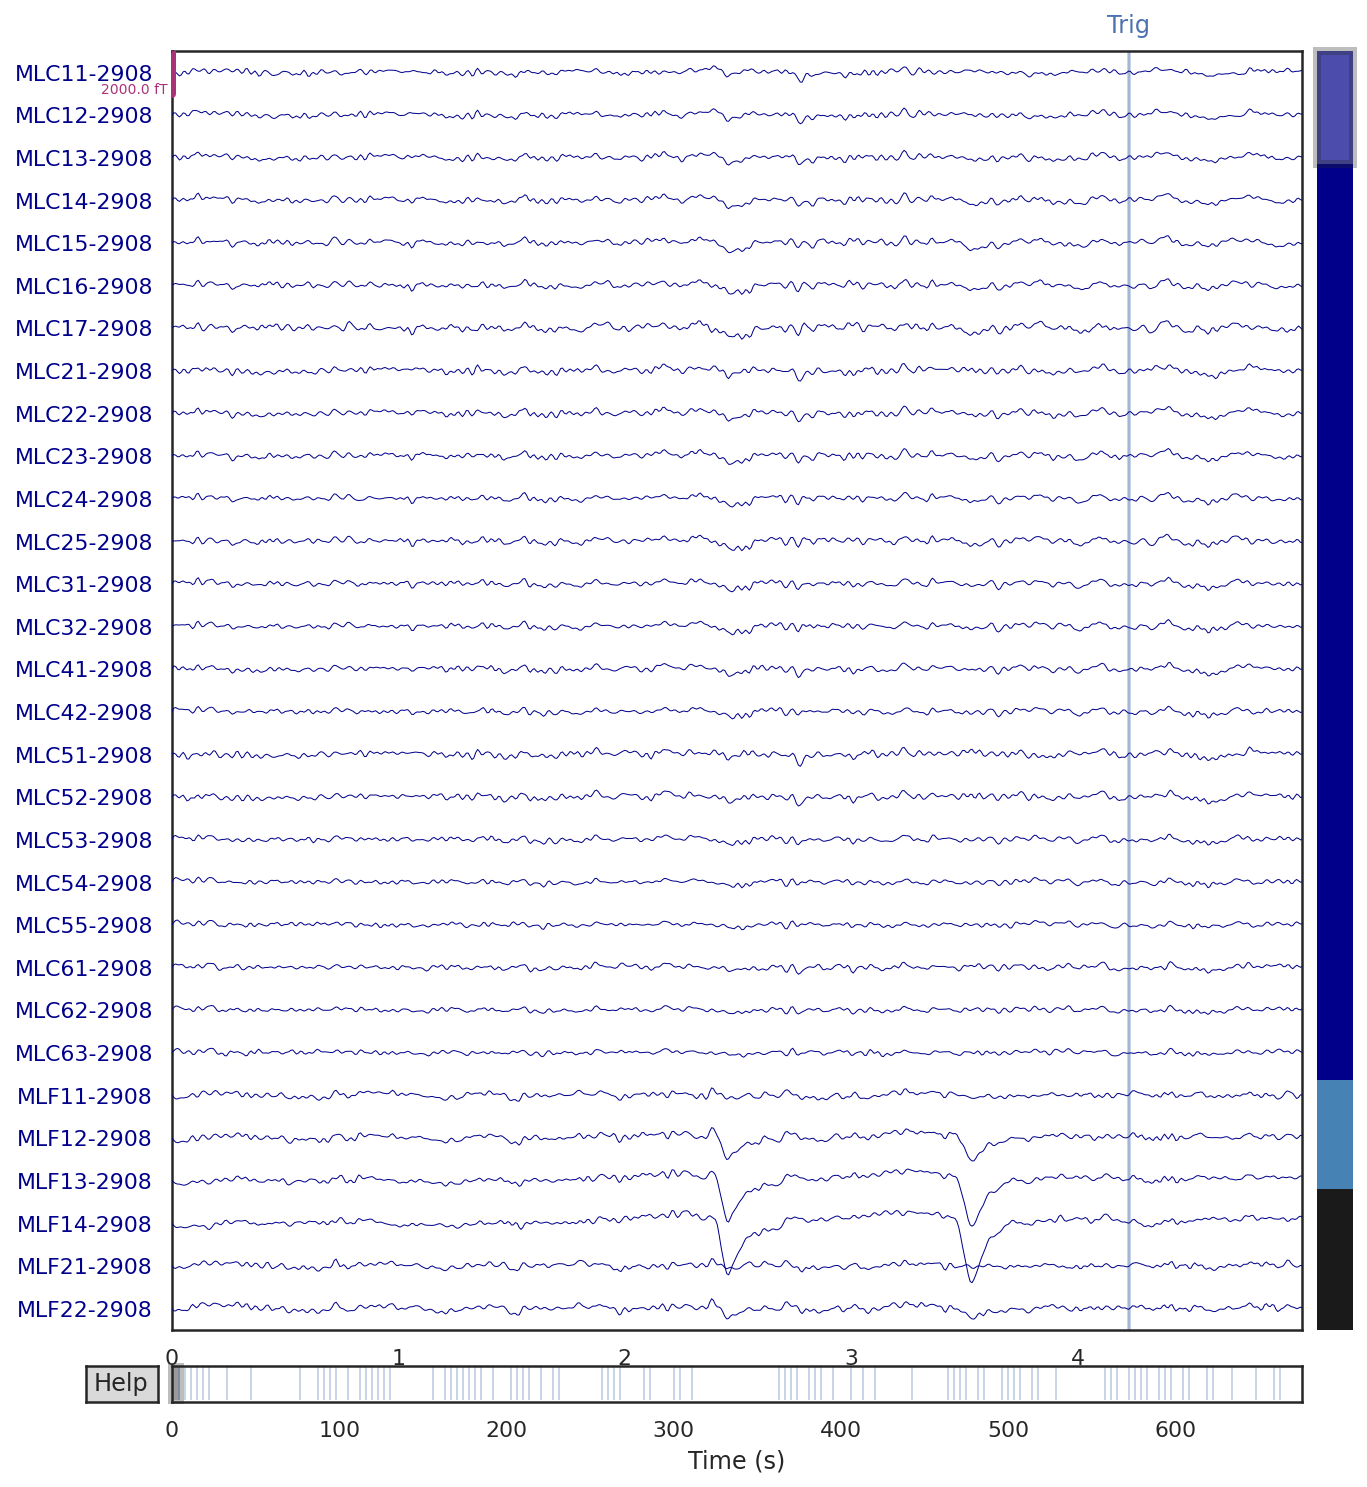

In [49]:
_ = raw.plot(duration=5, n_channels=30)

Do you see how channels appear less "jagged"?
The signal should be cleaner from noise now.

# Getting the Events

During the experiment, the brain signals are recorded continuously.
At the same time, some external stimuli are occurring.
We need to encode the nature of these external events and time-lock them with the recorded signal.
These events will constitute the associated metadata to the signal e.g. whether at time = 200 the participant saw a normal or scrambled face.

Let's see how events occurred in time!

##### Loading the events <a class="tocSkip"></a>

In [50]:
events = mne.find_events(raw, stim_channel='UPPT001')
events


array([[  506,     0,     3],
       [  939,     0,     3],
       [ 1371,     0,     3],
       [ 1806,     0,     3],
       [ 2237,     0,     1],
       [ 2673,     0,     1],
       [ 3106,     0,     2],
       [ 3539,     0,     2],
       [ 3971,     0,     1],
       [ 4404,     0,     2],
       [ 4837,     0,     2],
       [ 5270,     0,     2],
       [ 5706,     0,     1],
       [ 6137,     0,     2],
       [ 6570,     0,     2],
       [ 7006,     0,     2],
       [ 7437,     0,     2],
       [ 7870,     0,     2],
       [ 8305,     0,     2],
       [ 8739,     0,     2],
       [ 9170,     0,     1],
       [ 9605,     0,     2],
       [10037,     0,     2],
       [10472,     0,     1],
       [10903,     0,     1],
       [11337,     0,     1],
       [11772,     0,     1],
       [12205,     0,     2],
       [12636,     0,     1],
       [13072,     0,     2],
       [13503,     0,     1],
       [13936,     0,     1],
       [14372,     0,     1],
       [14

First column is a timestamp, second is usually 0s, this one is the label (here, either 1, 3, or 3).

##### Plotting <a class="tocSkip"></a>

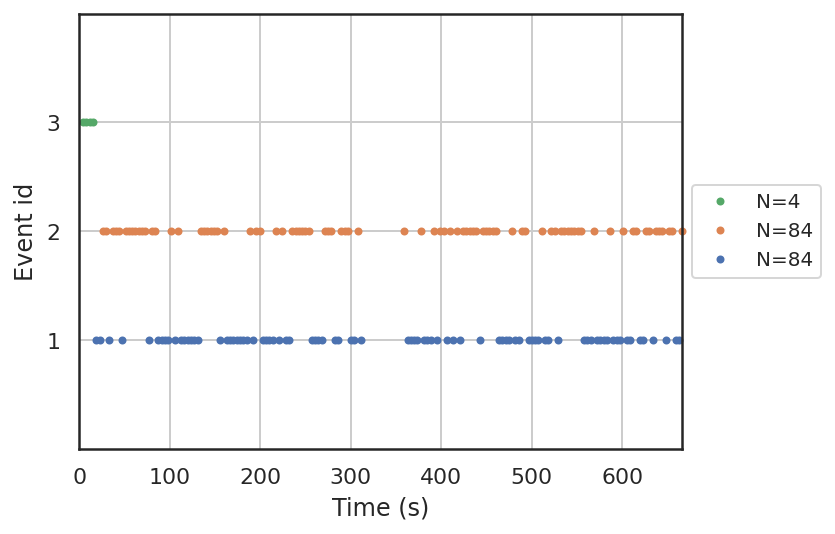

In [51]:
# plot the events to get an idea of the paradigm
mne.viz.plot_events(events, raw.info['sfreq'])

event_ids = {"faces": 1, "scrambled": 2}

# Epoching

Now it's time to "merge" the events (sequence of markers of what was happening in the experiment room) with the data (sequence of data points of what was happening inside the brain).
We'll combine the information contained in Raw data with Events to form Epochs:

Select the epochs considering Raw, Events, and a time window.
Use only the channels we selected.

##### Making epochs <a class="tocSkip"></a>

In [27]:
tmin, tmax = -0.2, 0.6
baseline = None  # no baseline as high-pass is applied
reject = dict(mag=5e-12)

epochs = mne.Epochs(raw, events, event_ids, tmin, tmax, picks=picks,
                    baseline=baseline, preload=True, reject=reject)

Not setting metadata
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Loading data for 168 events and 97 original time points ...
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
1 bad epochs dropped


The Epochs object is often more human-friendly.
We can see the two classes of epochs as defined by events:
"faces" and "scrambled"

In [49]:
epochs

Number of events,167
Events,faces: 84scrambled: 83
Time range,-0.200 – 0.600 sec
Baseline,off


##### Plotting <a class="tocSkip"></a>

Let's visualize the time series but now structured as epochs.
https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html#plotting-epochs-as-time-series

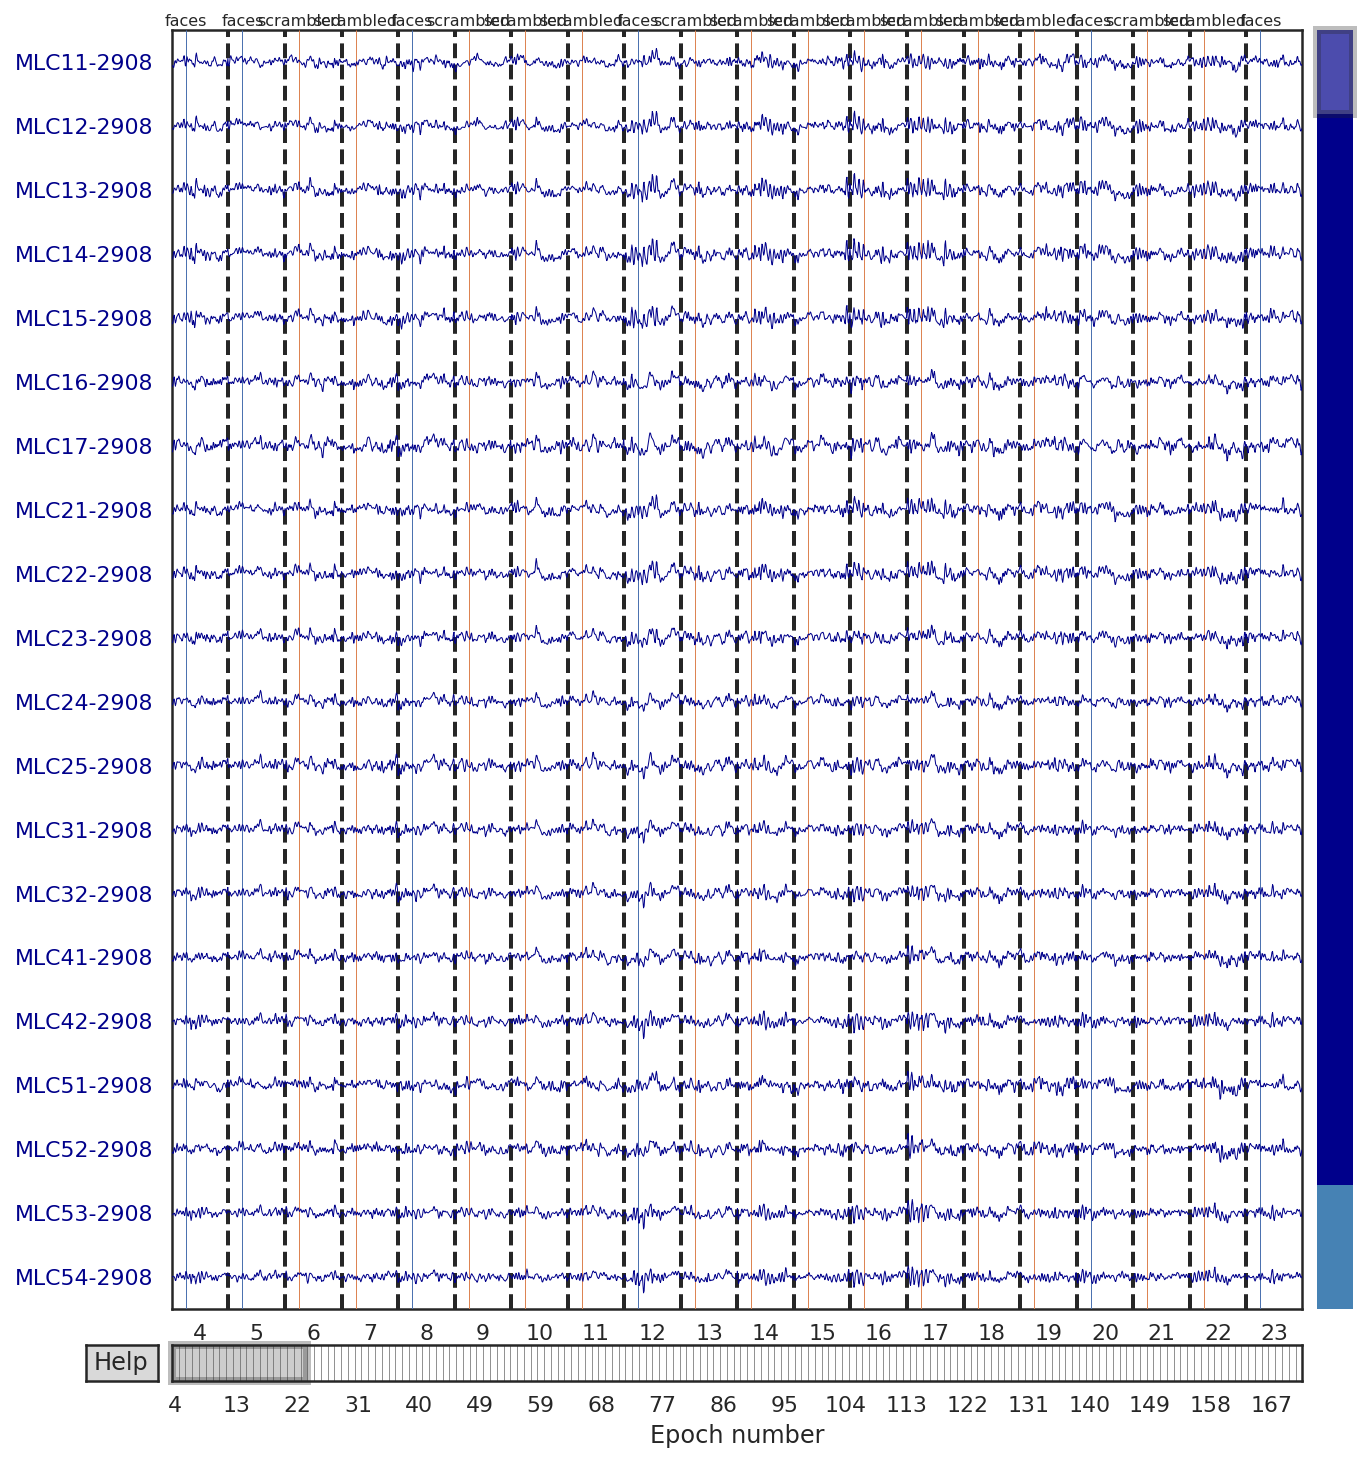

In [28]:
_ = epochs.plot(events=events, event_id=event_ids)

# Cleaning

## Automatically finding bad channels

Bad channels are traditionally found via visual inspection, or more recently with automated methods.
Before, we removed those which were encoded in the raw metadata, but there might be more.
We'll use Autoreject (https://autoreject.github.io/index.html), which utilized machine learning methods to determine bad channels (for more, see: https://hal.archives-ouvertes.fr/hal-01313458/document).

##### Applying autoreject/ransac <a class="tocSkip"></a>

In [ ]:
# WARNING: VERY slow!
ch_before = epochs.info.ch_names
print(f"Before:\t{len(ch_before)} channels")
ransac = Ransac(verbose='progressbar', n_jobs=1)
epochs = ransac.fit(epochs)
ch_after = epochs.info.ch_names
print(f"After:\t{len(ch_after)} channels")

Let's print the bad channels:

In [ ]:
print('\n'.join(ransac.bad_chs_))

## Finding and fixing artifacts

Remember we're not measuring an isolated system!

There are many things which can alter our measurements, such as:

- Heartbeat.
- Moving muscles (including eyes).
- Building vibrations.
- And many more!

You can check MNE documentation for a more detailed description https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html?highlight=artifact

For this lecture, we'll just apply one of the most common techniques, independent component analysis (ICA).
It tries to separate different components from an aggregated signal.
You can think of it as trying to separate e.g. the guitar, voice, and keyboards from a music file.
The same is applied here, but for the heartbeat, building vibrations, etc.
Those detected as "artifacts" can be removed from the signal.

##### Applying ICA <a class="tocSkip"></a>

In [ ]:
# WARNING: Slow!
# Fit ICA, find and remove major artifacts
ica = ICA(n_components=0.95, max_iter='auto', random_state=0)
ica.fit(epochs, decim=1, reject=reject)

# compute correlation scores, get bad indices sorted by score
eog_epochs = create_eog_epochs(epochs, ch_name='MRT31-2908', reject=reject)
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='MRT31-2908')
ica.plot_scores(eog_scores, eog_inds)  # see scores the selection is based on
ica.plot_components(eog_inds)  # view topographic sensitivity of components
ica.exclude += eog_inds[:1]  # we saw the 2nd ECG component looked too dipolar
ica.plot_overlay(eog_epochs.average())  # inspect artifact removal
ica.apply(epochs)  # clean data, default in place

evoked = [epochs[k].average() for k in event_ids]

contrast = combine_evoked(evoked, weights=[-1, 1])  # Faces - scrambled

evoked.append(contrast)

for e in evoked:
    e.plot(ylim=dict(mag=[-400, 400]))

# plt.show()

# estimate noise covarariance
noise_cov = mne.compute_covariance(epochs, tmax=0, method='shrunk',
                                   rank=None)

# Classifying

**Remember the goal:**
Can we guess if the user is seeing a face?

We'll use machine learning methods to automatically separate the data into "the subject saw a scrambled face" (or label 0) and "the subject saw a normal face" (label 1).
The classifier will, based on the data we use as input, draw a "line" for us to separate the classes.
You can think of an advanced version of linear regression.

![Classifier comparison](img/lec8/classifier-comparison.png)
<img src="img/lec8/classifier-comparison.png" width="300">

(from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

## Reshaping the data

First, we want to put the data in a form that is convenient for the classifier.
We'll start by separating the data corresponding to the "faces" class and the "scrambled" class.
Then the reshape operation is done.
Finally we put all data together ready for the classifier.

Don't worry about the small details in this subsection!

##### Code <a class="tocSkip"></a>

In [59]:
faces = epochs["faces"].get_data()
scrambled = epochs["scrambled"].get_data()

In [61]:
faces.shape

(84, 303, 97)

Can you identify what is in each dimension?

We'll also downsample the data a bit:

In [66]:
def _find_dividend_for_remainder(dividend, divisor, target_remainder=0):
    """Operation"""
    term = 0
    remainder = 1 
    while remainder != target_remainder:
        remainder = (dividend - term) % divisor
        term += 1

    return dividend - term + 1

def vectorize_epoch_data(epoch_data, frames):
    """Transform epoch data into tensor of shape: event x time_frame*channels."""

    time_axis = 2  # axes: event x channel x time

    data = epoch_data.get_data()

    # Get how many points to preserve to form equal split time frames
    mod_time = _find_dividend_for_remainder(
        dividend=data.shape[time_axis], divisor=frames
    )

    # Split data into frames of the same size, discarding points that would prevent that
    split = np.split(data[:, :, :mod_time], frames, axis=time_axis)

    # Average time points within each frame and concat all now averaged frames
    mean = np.hstack([np.mean(split_part, axis=2) for split_part in split])

    return mean


In [62]:
epochs

Number of events,167
Events,faces: 84scrambled: 83
Time range,-0.200 – 0.600 sec
Baseline,off


In [71]:
faces = _vectorize_epoch_data(epochs["faces"], 7)
scrambled = _vectorize_epoch_data(epochs["scrambled"], 7)

We have a smaller representation of the initial data ready for the classifier.
This will make "training" the classifier faster.
Don't worry about these details!

The thing that you need to know:
we have the brain signal clean now, we split it into the two classes, and reshape it for the machine learning method.

In [69]:
faces.shape

(84, 2121)

In [70]:
faces

array([[ 8.57533306e-14,  1.83888571e-12,  4.93564229e-12, ...,
        -1.26098222e-13, -1.04186820e-13,  2.16254401e-14],
       [ 4.06778289e-13, -7.86977748e-13,  3.52588139e-13, ...,
        -8.72030405e-14, -3.14645939e-14,  5.68782686e-14],
       [-1.18572794e-13, -1.63850419e-12, -2.55086335e-12, ...,
        -9.36121433e-14, -1.10016264e-13,  6.61822595e-14],
       ...,
       [-6.91979119e-13, -6.01461125e-13, -1.74736117e-12, ...,
        -1.80695139e-14, -3.75954757e-14,  1.51188340e-13],
       [-2.36162639e-13,  8.48875851e-13,  2.09959747e-12, ...,
        -9.14442995e-14, -8.91889388e-14,  2.60877602e-14],
       [ 3.57064096e-13, -8.13655006e-13, -5.96705177e-13, ...,
        -1.81939035e-14,  6.70990909e-15,  3.01494201e-14]])

First we will put the data together (for both classes) in a shape adequate for the classifier.
We will stack all data together:

In [97]:
X = np.vstack((faces, scrambled))

X.shape

(167, 2121)

## Making the labels

Then, we make the labels that accompany all data instances.
If the user saw a normal face, give a "1", and if the user saw a scrambled face, give a "0".

##### Code <a class="tocSkip"></a>

In [107]:
y_rel = np.ones(len(faces), dtype=int)
y_irrel = np.zeros(len(scrambled), dtype=int)

print("Labels:")
print(y_rel)
print(y_irrel)

print("\nShapes:")
print(y_rel.shape)
print(y_irrel.shape)

Labels:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]

Shapes:
(84,)
(83,)


In [108]:
y = np.hstack((y_rel, y_irrel))

print(y)
print(y.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(167,)


In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0)

## Instantiating the classifier

Let's take a simple enough model that has shown good performance for similar tasks.
Notice that our data is MEG and the article uses EEG and fMRI!
We're taking shortcuts!
https://www.sciencedirect.com/science/article/pii/S1053811915008460?via%3Dihub

##### Code <a class="tocSkip"></a>

In [99]:
# LDA settings.
solver = "lsqr"
shrinkage = "auto"

lda = LinearDiscriminantAnalysis(solver, shrinkage)

## Fitting

Then we "fit" or "train" the classifier to be able to predict whether a user saw a face or not based solely on the brain signals.

In [101]:
lda = lda.fit(X_train, y_train)

## Predicting

Our classifier is fitted now, and we can use it for prediction.
Let's predict the labels associated with the brain signals we separated for testing.

In [110]:
y_pred = lda.predict(X_test)
print(y_pred)

[0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1]


NOPE How do we know if this is a good result or not?
We compare it to the true labels, since those are known.
But how exactly?
We will use a strong metric to evaluate a classifier, the area under the ROC curve.
It takes into account all types of errors ("1" where should have been "0" and vice versa) and output a single number.

What do should you know about this metric?
Only that the closer to 1, the better our results are.

<div class="alert alert-block alert-danger">
<h2><img src="img/logo/warning.png" width="20" align="left"><a class="tocSkip"></a>&nbsp;Important</h2>
    
Same as with choosing a classifier, metrics must be chosen with a rationale and must be well understood.
Here we are skipping details since it'd be a lecture or course on its own.
</div>

##### Code <a class="tocSkip"></a>

In [1]:
from sklearn.metrics import accuracy_score

print(f"True labels:\t{y_true}")
print(f"Predicte labels:\t{y_pred}")
accuracy_score(y_test, y_pred)

NameError: name 'y_true' is not defined

Good news!
We've obtained a hich accuracy score, which means we separate the classes well enough.

# Conclusions

A bunch of labels may not be the most flamboyant results ever, BUT think of the implications:

<div class="alert alert-block alert-info">
    Now, <strong>ONLY with some given brain signals</strong> in similar experimental conditions, you can <strong>predict whether the user is seen a face or not</strong>.

No clicks, button presses, no voice commands, no eye movements:
<strong>only passive observation</strong>.

</div>

Remember this is just a toy example with readily available datasets and we have taken many shortcuts, but still let's ask ourselves the question: how would we use this in interactive settings?

Maybe we could have some kind of "Brain CAPTCHA" to crowsource whether an unkown image is a face or not?

![CAPTCHA](img/lec8/captcha.jpeg)

This idea is based on this paper:
https://dl.acm.org/doi/10.1145/3313831.3376288

# Appendix

## Meaning of `object.info` keys


Some examples that apply to other data.

```
- bads: channels that are too noisy or have near-zero activity.
- ch_names: names of the channels.
- chs: types of channels.
- highpass: cutoff below this frequency ("high frequencies pass").
- lowpass: cutoff above this frequency ("low frequencies pass").
- meas_date: measurement date.
- nchan: number of channels.
- projs: projections from one space to another, used e.g. to eliminate noise.
- sfreq: sample rate of the data.
```

## Modifying data in place

In [2]:
____________________ = lambda: print("-" * 20)

____________________()
arr = np.arange(5)[::-1]
print(f"Making original array:\t{arr}")
____________________()
np.sort(arr)
print("Sorted the array NOT in place!")
print(f"Original array:\t{arr}")
arr_sorted = np.sort(arr)
print(f"Assigned sorted to another array")
print(f"New array:\t{arr_sorted}")

____________________()
arr = np.arange(5)[::-1]
print(f"Making original array:\t{arr}")
____________________()
arr.sort()
print("Sorted the array IN PLACE!")
print(f"Original array:\t{arr}")
arr_sorted = arr.sort()
print(f"Assigned sorted to another array")
print(f"New array:\t{arr_sorted}")
____________________()

--------------------
Making original array:	[4 3 2 1 0]
--------------------
Sorted the array NOT in place!
Original array:	[4 3 2 1 0]
Assigned sorted to another array
New array:	[0 1 2 3 4]
--------------------
Making original array:	[4 3 2 1 0]
--------------------
Sorted the array IN PLACE!
Original array:	[0 1 2 3 4]
Assigned sorted to another array
New array:	None
--------------------
